# TRABAJO FINAL

### Nombres:
  - Shirley Tenorio Oblitas
  - Gabriel Ruben Flores Verástegui
  - Raul Sergio Espejo Ticona
  - Victor Hugo Achocalla Romero

El presente notebook tiene el resultado de la mejor predicción obtenida, sin embargo se hicieron otras pruebas las cuales estan disponibles en https://github.com/vachocalla/WidsDatathon2020Dinamita.git

In [13]:
import pandas as pd
from datetime import datetime, date, time, timedelta
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap

In [6]:
# F,M  =>   0, 1
def etiquetar_columnas(data, columnas_categoricas):
    lb=[]
    for columna in columnas_categoricas:
        l=LabelEncoder()
        lb.append(l.fit(list(data[columna].dropna())))
    
    return lb

def transformar_etiquetas(data, l, columnas_categoricas):
    i=0
    for columna in columnas_categoricas:
        data.loc[data[columna].notnull(),columna] = l[i].transform( data.loc[data[columna].notnull(), columna] )
        i=i+1

# Funcion para mostar cadenas en color
def printC(msg, type):
    if type=="err":
        print('\x1b[1;31m' + msg + '\x1b[0m')
    elif type=="succ":
        print('\x1b[1;32m' + msg + '\x1b[0m')
    elif type=="warn":
        print('\x1b[1;33m' + msg + '\x1b[0m')
    elif type=="prim":
        print('\x1b[1;34m' + msg + '\x1b[0m')
    else:
        print('\x1b[1;37m' + msg + '\x1b[0m')

## 1. Carga de Datos

In [7]:
# Carga de datos
# Diccionario de datos
df_dictionary = pd.read_csv('Dictionary.csv')
# Modelos de estructura de datos para enviar la solución
df_samplesubmission = pd.read_csv('samplesubmission.csv')
# Identificadores de los item a ser probados
df_solution_template = pd.read_csv('solution_template.csv')
# Datos de entrenamiento
df_train_training_v2 = pd.read_csv('training_v2.csv')
# Datos de prueba
df_test_unlabeled = pd.read_csv('unlabeled.csv')

printC("*** Numero columnas y filas de datos de entrenamiento ***","succ")
display( df_train_training_v2.shape )
printC("*** Numero columnas y filas de datos de prueba ***","succ")
display( df_test_unlabeled.shape )

*** Numero columnas y filas de datos de entrenamiento ***


(91713, 186)

*** Numero columnas y filas de datos de prueba ***


(39308, 186)

## 2. Análisis descriptivo

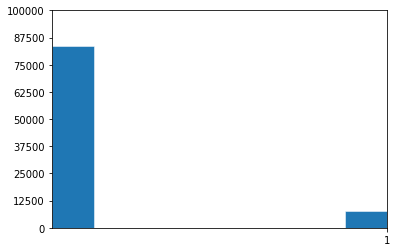

In [8]:
# plot:
fig, ax = plt.subplots()

ax.hist(df_train_training_v2["hospital_death"], bins=8, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 1), xticks=np.arange(1, 8),
       ylim=(0, 100000), yticks=np.linspace(0, 100000, 9))

plt.show()

In [9]:
# conteo de muertes por edad y género
import plotly.express as px
fig = px.histogram(df_train_training_v2[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=df_train_training_v2[['age','gender','hospital_death','bmi']].columns)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# conteo de muertes por peso y género
import plotly.express as px
fig = px.histogram(df_train_training_v2[['weight','gender','hospital_death','bmi']].dropna(), x="weight", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=df_train_training_v2[['weight','gender','hospital_death','bmi']].columns)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# peso vs edad
import plotly.express as px
df = px.data.tips()
fig = px.box(df_train_training_v2, x="age", y="weight")
fig.show()

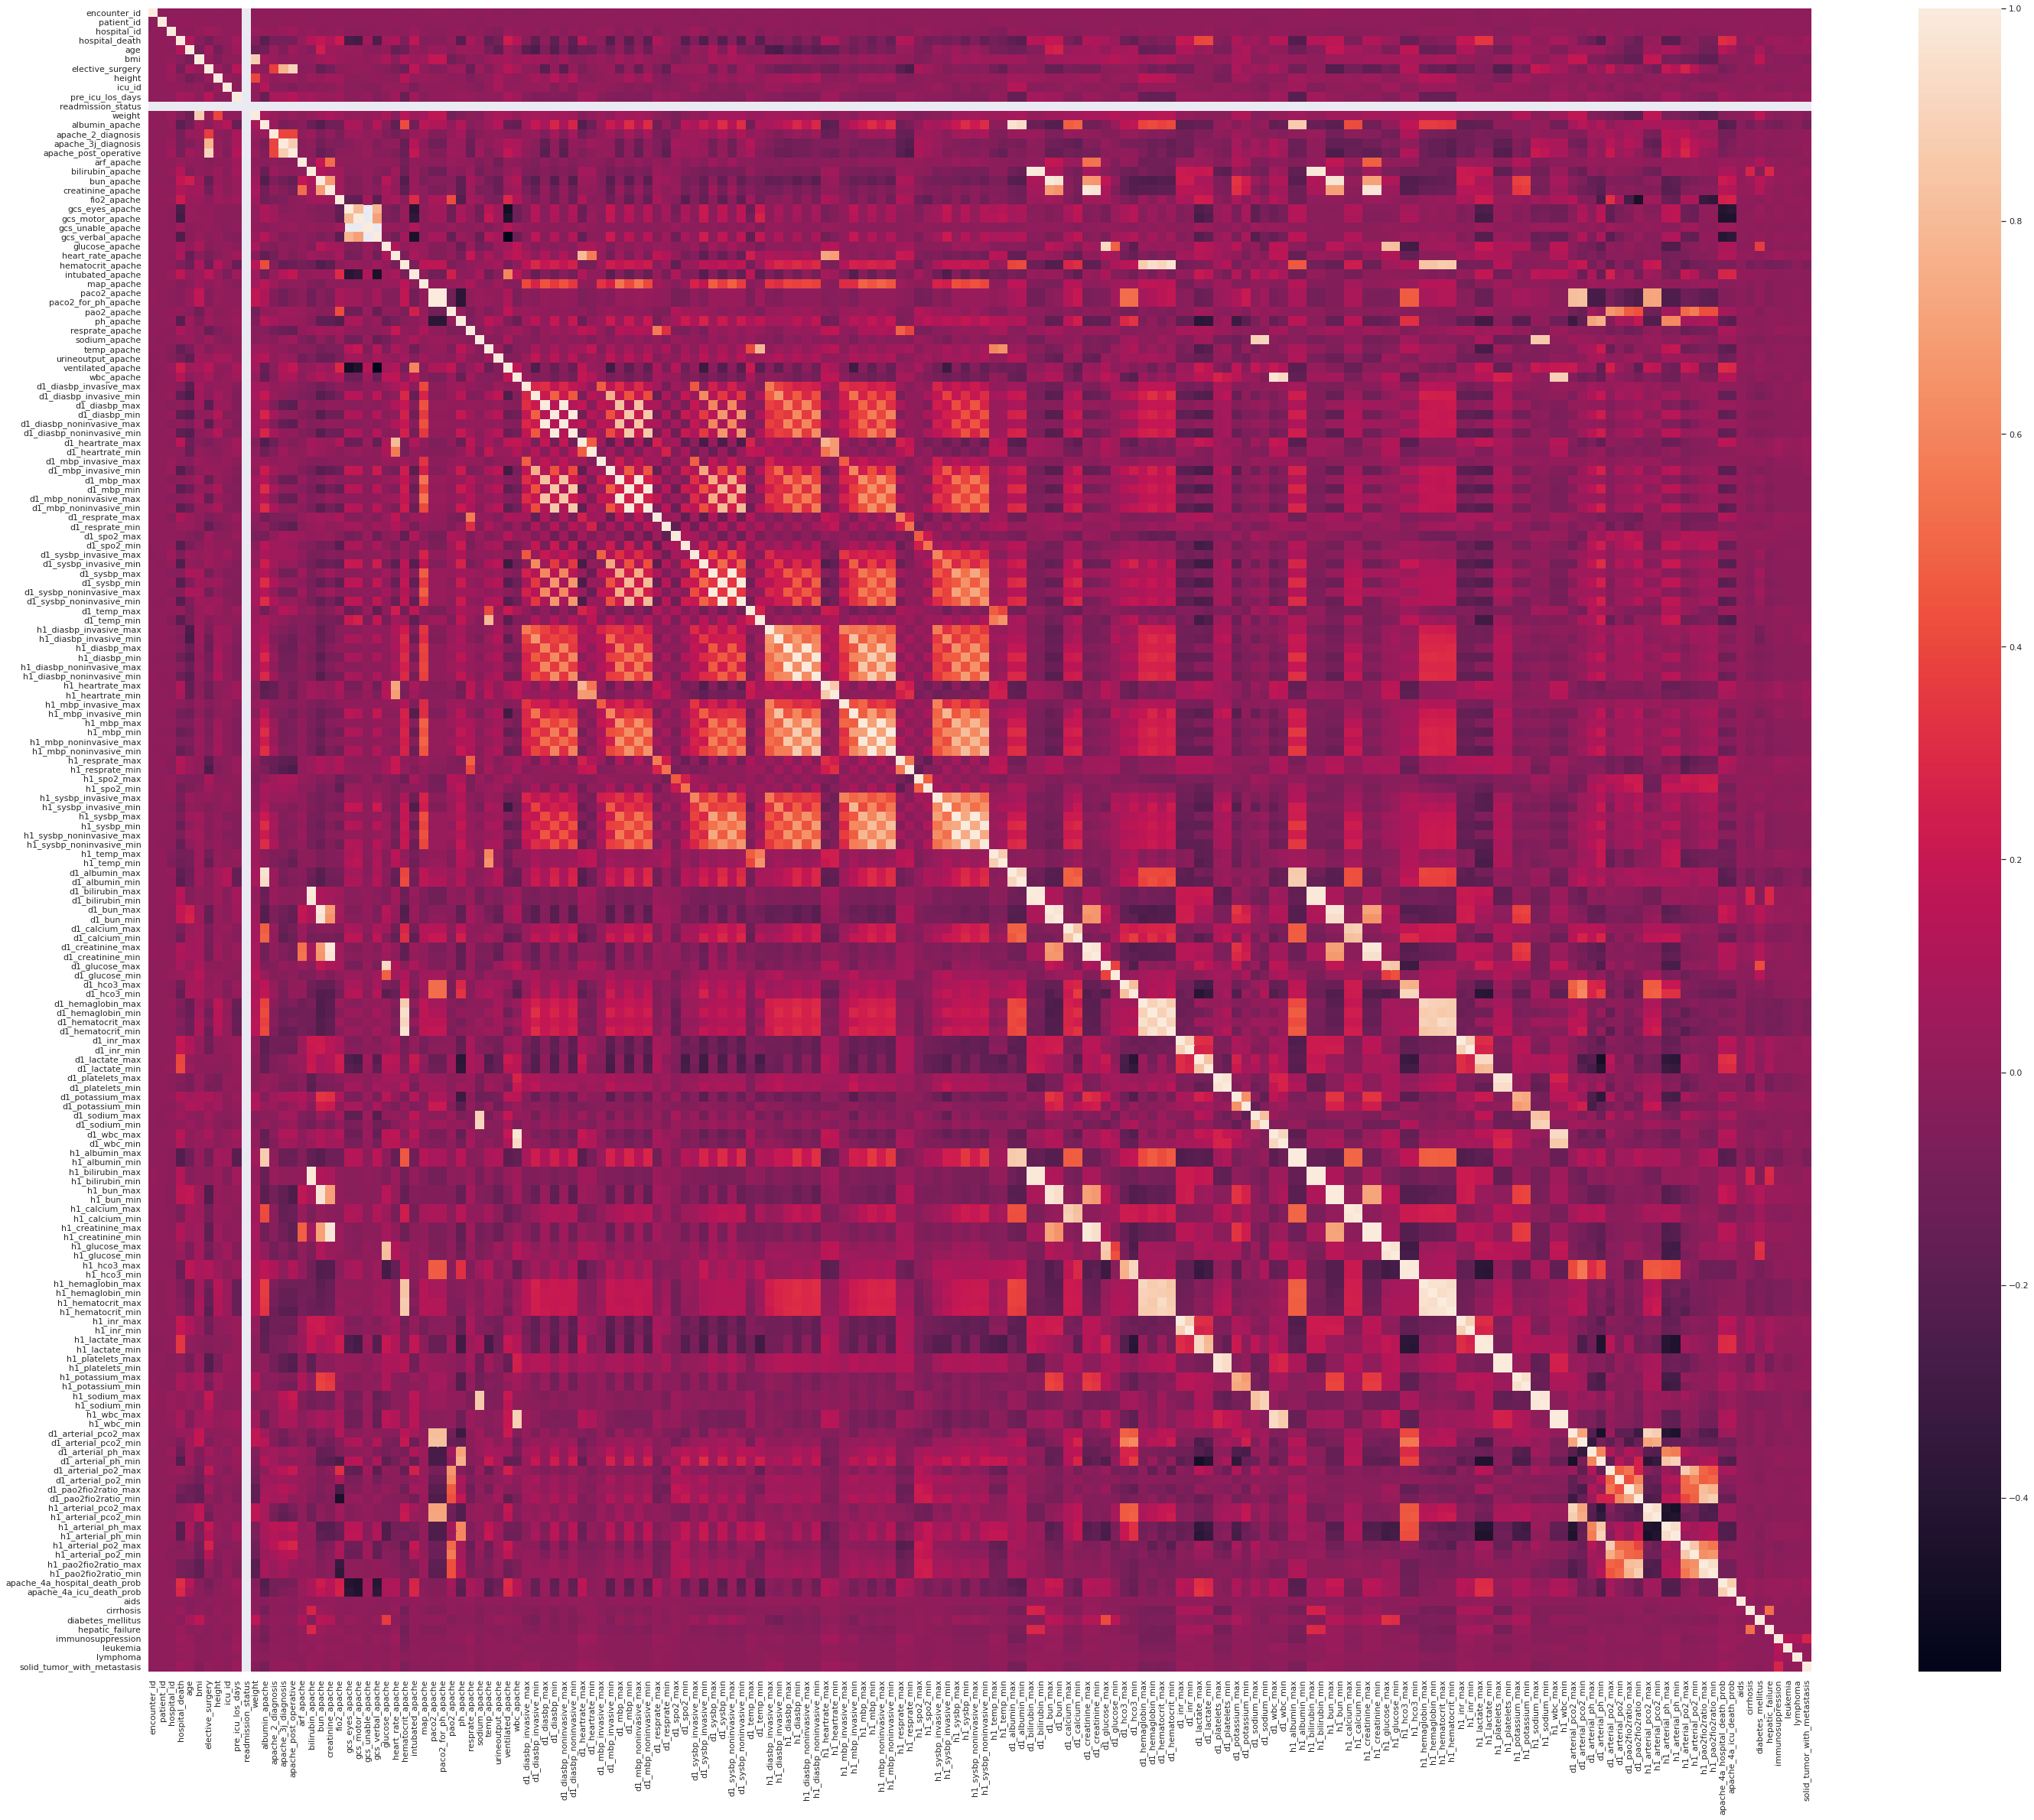

In [14]:
# Matriz de correlación
corrmat =df_train_training_v2.corr()
sns.set(rc = {'figure.figsize':(50,40)})
sns.heatmap(corrmat,annot =False, square =True);

In [15]:
df_dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


In [16]:
# Elimanando columas que no ingresan en el entrenamiento
# PORQUE QUITAMOS ESTO 'encounter_id','patient_id','hospital_death','readmission_status'
columnas_train = [x for x in df_train_training_v2.columns if x not in ['encounter_id','patient_id','hospital_death','readmission_status']]
printC("*** Columnas que no participan del entrenamiento ***","succ")
print( textwrap.fill( ", ".join(columnas_train) , 140) )

# Seleccionando columnas categoricas
columnas_categoricas = []
for columna in columnas_train:
    if(df_train_training_v2[columna].dtypes=='object'):
        columnas_categoricas.append(columna)

printC("\n*** Columnas categorias seleccionadas ***","succ")
print( textwrap.fill( ", ".join(columnas_categoricas) , 140) )

*** Columnas que no participan del entrenamiento ***
hospital_id, age, bmi, elective_surgery, ethnicity, gender, height, hospital_admit_source, icu_admit_source, icu_id, icu_stay_type,
icu_type, pre_icu_los_days, weight, albumin_apache, apache_2_diagnosis, apache_3j_diagnosis, apache_post_operative, arf_apache,
bilirubin_apache, bun_apache, creatinine_apache, fio2_apache, gcs_eyes_apache, gcs_motor_apache, gcs_unable_apache, gcs_verbal_apache,
glucose_apache, heart_rate_apache, hematocrit_apache, intubated_apache, map_apache, paco2_apache, paco2_for_ph_apache, pao2_apache,
ph_apache, resprate_apache, sodium_apache, temp_apache, urineoutput_apache, ventilated_apache, wbc_apache, d1_diasbp_invasive_max,
d1_diasbp_invasive_min, d1_diasbp_max, d1_diasbp_min, d1_diasbp_noninvasive_max, d1_diasbp_noninvasive_min, d1_heartrate_max,
d1_heartrate_min, d1_mbp_invasive_max, d1_mbp_invasive_min, d1_mbp_max, d1_mbp_min, d1_mbp_noninvasive_max, d1_mbp_noninvasive_min,
d1_resprate_max, d1_resprate_mi

In [17]:
# Unimos los datos categoricos de Entrenamiento y Prueba en uno solo
df_dataAllCategoricos = pd.concat([df_train_training_v2[columnas_categoricas],df_test_unlabeled[columnas_categoricas]])
printC("Nuevo dataframe: Unimos los datos categoricos de Entrenamiento y Prueba en uno solo", "succ")
display( df_dataAllCategoricos.shape )
display( df_dataAllCategoricos.head() )

Nuevo dataframe: Unimos los datos categoricos de Entrenamiento y Prueba en uno solo


(131021, 8)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma


In [18]:
# Estableciendo valores numericos a columnas categoricas
l = etiquetar_columnas(df_dataAllCategoricos, columnas_categoricas)

printC("*** Columnas Categoricas de datos de Entrenamiento ***", "succ")
display( df_train_training_v2[columnas_categoricas].head() )

transformar_etiquetas( df_train_training_v2, l, columnas_categoricas)
printC("\n*** Columnas Categoricas de datos de Entrenamiento con valores numericos ***", "succ")
display( df_train_training_v2[columnas_categoricas].head() )

transformar_etiquetas( df_test_unlabeled,l,columnas_categoricas )
printC("\n*** Columnas Categoricas de datos de Prueba con valores numericos ***", "succ")
display( df_test_unlabeled[columnas_categoricas].head() )

*** Columnas Categoricas de datos de Entrenamiento ***


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma



*** Columnas Categoricas de datos de Entrenamiento con valores numericos ***


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,2,1,4,1,0,2,9,0
1,2,0,4,1,0,5,8,6
2,2,0,3,0,0,5,5,3
3,2,0,8,2,0,2,0,0
4,2,1,NaN,0,0,5,10,7



*** Columnas Categoricas de datos de Prueba con valores numericos ***


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,2,1,3,0,0,6,7,4
1,2,0,8,2,0,5,7,4
2,0,1,8,2,0,0,0,0
3,2,1,8,2,0,5,8,6
4,2,1,3,0,0,6,7,4


In [19]:
# tranformar los valores de las variables categoricas a float
for df in [df_train_training_v2, df_test_unlabeled]:
    for columna in columnas_categoricas:
        df[columna] = df[columna].astype(float)

printC("\n*** Columnas Categoricas de datos de Entrenamiento con valores numericos (float) ***", "succ")
display( df_train_training_v2[columnas_categoricas].head() )
printC("\n*** Columnas Categoricas de datos de Prueba con valores numericos (float) ***", "succ")
display( df_test_unlabeled[columnas_categoricas].head() )


*** Columnas Categoricas de datos de Entrenamiento con valores numericos (float) ***


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,2.0,1.0,4.0,1.0,0.0,2.0,9.0,0.0
1,2.0,0.0,4.0,1.0,0.0,5.0,8.0,6.0
2,2.0,0.0,3.0,0.0,0.0,5.0,5.0,3.0
3,2.0,0.0,8.0,2.0,0.0,2.0,0.0,0.0
4,2.0,1.0,NaN,0.0,0.0,5.0,10.0,7.0



*** Columnas Categoricas de datos de Prueba con valores numericos (float) ***


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,2.0,1.0,3.0,0.0,0.0,6.0,7.0,4.0
1,2.0,0.0,8.0,2.0,0.0,5.0,7.0,4.0
2,0.0,1.0,8.0,2.0,0.0,0.0,0.0,0.0
3,2.0,1.0,8.0,2.0,0.0,5.0,8.0,6.0
4,2.0,1.0,3.0,0.0,0.0,6.0,7.0,4.0


In [20]:
indice_categorias = [ columnas_train.index(x) for x in columnas_categoricas ]

objetivo = df_train_training_v2['hospital_death']

In [21]:
# Estamos utilizando el algoritmo 'lgb'

#Establecimiento de parametros para el algoritmo de entrenamiento
param = {'task': 'train',
         'boosting': 'gbdt',
         'objective':'binary',
         'metric': 'auc',
         'num_leaves': 30,
         'min_data_in_leaf': 90,
         'learning_rate': 0.01,
         'max_depth': 15,
         'feature_fraction': 0.1,
         'bagging_freq': 1,
         'bagging_fraction': 0.75,
         'use_missing': True,
         'nthread': 4
        }

# Usamos StratifiedKFold dividir los datos de Entrenamiento en porciones
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=512)

# Creamos la variable para alamenar todas las predicciones
resultados_predicciones_parciales = np.zeros(len(df_train_training_v2))

# lista de scores obtenidos de los modelos para cada porcion de datos de Entrenamiento
r=[]
# variable para almacenar todas precicciones
predictions = np.zeros(len(df_test_unlabeled))

In [27]:
for fold_, (train_idx, test_idx) in enumerate(folds.split( df_train_training_v2, objetivo.values)):
    # train_idx, test_idx: Porcion extraida de los datos de Entrenamiento

    strLog = "Entrenamiento de Porcion NO {}".format(fold_)
    print(strLog)
    
    # Agregamos datos (train_idx, test_idx) al modelo 'lbg' para su entrenamiento
    train_data = lgb.Dataset( df_train_training_v2.iloc[train_idx][columnas_train], label=objetivo.iloc[train_idx] )
    test_data = lgb.Dataset( df_train_training_v2.iloc[test_idx][columnas_train], label=objetivo.iloc[test_idx], reference=train_data )

    # Ahora entrenamos al modelo 'lgb'
    num_round = 7000
    modelo_lgb_entrenamiento = lgb.train(param, train_data, num_round, valid_sets=test_data, early_stopping_rounds=200, verbose_eval=400, categorical_feature=indice_categorias)
    resultados_predicciones_parciales[test_idx] = modelo_lgb_entrenamiento.predict( df_train_training_v2.iloc[test_idx][columnas_train], num_iteration=modelo_lgb_entrenamiento.best_iteration )
   
    # calculamos el score del modelo
    a = roc_auc_score(objetivo.loc[test_idx], modelo_lgb_entrenamiento.predict(df_train_training_v2.loc[test_idx,columnas_train].values, num_iteration=modelo_lgb_entrenamiento.best_iteration))
    r.append(a)
    
    #predictions
    predictions += modelo_lgb_entrenamiento.predict(df_test_unlabeled[columnas_train], num_iteration=modelo_lgb_entrenamiento.best_iteration) / folds.n_splits


Entrenamiento de Porcion NO 0


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.893375
[800]	valid_0's auc: 0.899619
[1200]	valid_0's auc: 0.902766
[1600]	valid_0's auc: 0.90405
[2000]	valid_0's auc: 0.905054
[2400]	valid_0's auc: 0.905382
[2800]	valid_0's auc: 0.906027
Early stopping, best iteration is:
[2943]	valid_0's auc: 0.906096
Entrenamiento de Porcion NO 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.902773
[800]	valid_0's auc: 0.908333
[1200]	valid_0's auc: 0.910161
[1600]	valid_0's auc: 0.910637
Early stopping, best iteration is:
[1653]	valid_0's auc: 0.910731
Entrenamiento de Porcion NO 2


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.899003
[800]	valid_0's auc: 0.905193
[1200]	valid_0's auc: 0.907788
[1600]	valid_0's auc: 0.908993
[2000]	valid_0's auc: 0.9098
[2400]	valid_0's auc: 0.910352
[2800]	valid_0's auc: 0.910349
Early stopping, best iteration is:
[2620]	valid_0's auc: 0.910412
Entrenamiento de Porcion NO 3


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.894608
[800]	valid_0's auc: 0.901107
[1200]	valid_0's auc: 0.903985
[1600]	valid_0's auc: 0.905258
[2000]	valid_0's auc: 0.906072
[2400]	valid_0's auc: 0.906824
[2800]	valid_0's auc: 0.907067
[3200]	valid_0's auc: 0.907309
[3600]	valid_0's auc: 0.907669
[4000]	valid_0's auc: 0.907802
Early stopping, best iteration is:
[4089]	valid_0's auc: 0.907995
Entrenamiento de Porcion NO 4


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.896538
[800]	valid_0's auc: 0.90189
[1200]	valid_0's auc: 0.903976
[1600]	valid_0's auc: 0.905355
[2000]	valid_0's auc: 0.906063
[2400]	valid_0's auc: 0.906737
[2800]	valid_0's auc: 0.907187
[3200]	valid_0's auc: 0.907368
[3600]	valid_0's auc: 0.907602
Early stopping, best iteration is:
[3658]	valid_0's auc: 0.907699
Entrenamiento de Porcion NO 5


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.903348
[800]	valid_0's auc: 0.910123
[1200]	valid_0's auc: 0.912464
[1600]	valid_0's auc: 0.913803
[2000]	valid_0's auc: 0.914074
Early stopping, best iteration is:
[1947]	valid_0's auc: 0.914148
Entrenamiento de Porcion NO 6


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.90487
[800]	valid_0's auc: 0.91036
[1200]	valid_0's auc: 0.912336
[1600]	valid_0's auc: 0.913571
[2000]	valid_0's auc: 0.914205
Early stopping, best iteration is:
[1926]	valid_0's auc: 0.914268
Entrenamiento de Porcion NO 7


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.889054
[800]	valid_0's auc: 0.894503
[1200]	valid_0's auc: 0.896332
[1600]	valid_0's auc: 0.897612
[2000]	valid_0's auc: 0.897996
[2400]	valid_0's auc: 0.898107
[2800]	valid_0's auc: 0.898365
Early stopping, best iteration is:
[2706]	valid_0's auc: 0.898408
Entrenamiento de Porcion NO 8


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.895168
[800]	valid_0's auc: 0.901854
[1200]	valid_0's auc: 0.9048
[1600]	valid_0's auc: 0.90636
[2000]	valid_0's auc: 0.907615
[2400]	valid_0's auc: 0.908392
[2800]	valid_0's auc: 0.90875
[3200]	valid_0's auc: 0.909185
[3600]	valid_0's auc: 0.909336
[4000]	valid_0's auc: 0.909653
Early stopping, best iteration is:
[3940]	valid_0's auc: 0.909695
Entrenamiento de Porcion NO 9


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 7, 8, 10, 11, 180, 181]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[400]	valid_0's auc: 0.906968
[800]	valid_0's auc: 0.913033
[1200]	valid_0's auc: 0.915012
[1600]	valid_0's auc: 0.915753
[2000]	valid_0's auc: 0.916053
[2400]	valid_0's auc: 0.91621
Early stopping, best iteration is:
[2206]	valid_0's auc: 0.916248


In [29]:
# Calculo del score general
scoreGeneral = roc_auc_score(objetivo, resultados_predicciones_parciales)
printC(str(scoreGeneral) , "prim")

# Media de los score de los modelos entrenados
print ("Media: "+str(np.mean(np.array(r))))
# desviacion estandar de los score de los modelos entrenados
print ("Desiacion Estandar: "+str(np.std(np.array(r))))

# Hallar las preducciones para el conjunto de datos de PRUEBA
df_predicciones = pd.DataFrame({'encounter_id': df_test_unlabeled['encounter_id']})
df_predicciones['hospital_death'] = predictions

# Exportamos los resultados de las predicciones a un archivo para su envio a Kaagle
df_predicciones.to_csv("submissionFinal.csv",index=False)

0.9092856770131742
Media: 0.9092540237666231
Desiacion Estandar: 0.004703051993660114


El presente notebook tiene el resultado de la mejor predicción obtenida, sin embargo se hicieron otras pruebas las cuales estan disponibles en https://github.com/vachocalla/WidsDatathon2020Dinamita.git